In [1]:
# Libraries
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Lux
using ComponentArrays
using LineSearches
using OrdinaryDiffEq
using OptimizationOptimisers
using Optimization
using OptimizationOptimJL
using Printf
using Random 
using SciMLSensitivity
using Plots
using DataFrames
using StableRNGs
using CSV

rng = StableRNG(1111)

  Activating project at `~/Desktop/General Case/SXS_1356`


StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

In [2]:
# Include utilities
include("utils.jl")

file2trajectory (generic function with 2 methods)

In [3]:
## Define the experiment parameters
mass_ratio = 1.0
model_params = [mass_ratio] # Just the mass ratio, at least for now
mass1 = 1.0/(1.0+mass_ratio)
mass2 = mass_ratio/(1.0+mass_ratio)

0.5

In [4]:
## Define the experiment parametersa
e₀ = 0.085   # optimized value is near 0.099
x₀ = 6.484530581221468
χ₀ = pi # optimized value is near 3.66
p₀ = x₀ * (1+e₀*cos(χ₀)) / mass1
u0 = Float32[χ₀, 0.0, p₀, e₀] # χ₀, ϕ₀, p₀, e₀
u0

4-element Vector{Float32}:
  3.1415927
  0.0
 11.866691
  0.085

In [5]:
# Time span
tspan = (5.20913f3, 6.78f3)
datasize = 1000
tsteps = range(tspan[1], tspan[2], length = datasize)
dt_data = tsteps[2] - tsteps[1]
dt = 10.0
num_optimization_increments = 100

100

# Data waveform

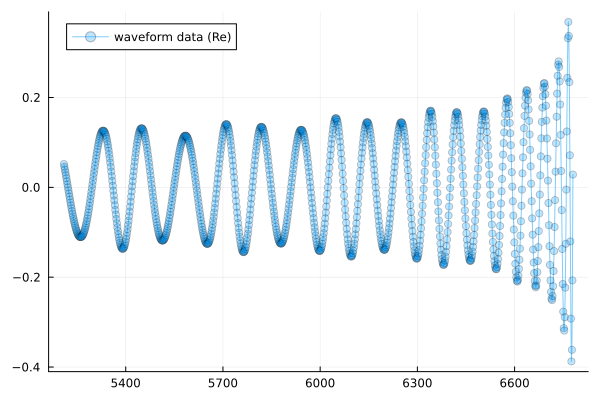

In [6]:
# Gather waveform data
x, y = file2trajectory(tsteps,"./trajectoryA.txt")
waveform_real = file2waveform(tsteps,"./waveform_real.txt")
x2, y2 = file2trajectory(tsteps,"./trajectoryB.txt")

# ploting the waveform
plt = plot(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Re)")

# Neural Network

In [7]:
# Define NN chi-phi
NN_chiphi = Chain((x) -> [cos(x[1]),1/abs(x[3]),1/sqrt(abs(x[3])),sqrt(abs(x[3])),x[3],sqrt(abs(x[3]))^3,x[3]^2,x[4],x[4]^2],
                Dense(9, 32, tanh),
                Dense(32, 2))                
NN_chiphi_params, st_chiphi  = Lux.setup(Xoshiro(), NN_chiphi)

params_chiphi = ComponentArray{Float64}(NN_chiphi_params)
nn_model_chiphi = StatefulLuxLayer(NN_chiphi, st_chiphi)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = WrappedFunction(#9),
        layer_2 = Dense(9 => 32, tanh_fast),  # 320 parameters
        layer_3 = Dense(32 => 2),       # 66 parameters
    ),
)

In [8]:
# Define NN p-e
NN_pe = Chain((x) -> [1/sqrt(abs(x[3]))^3,1/abs(x[3]),1/sqrt(abs(x[3])),sqrt(abs(x[3])),x[3],sqrt(abs(x[3]))^3,x[3]^2,x[4],x[4]^2,x[3]*x[4]],
                Dense(10, 32, tanh),
                Dense(32, 2))
NN_pe_params, st_pe = Lux.setup(Xoshiro(), NN_pe)

params_pe = ComponentArray{Float64}(NN_pe_params)
nn_model_pe = StatefulLuxLayer(NN_pe, st_pe)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = WrappedFunction(#11),
        layer_2 = Dense(10 => 32, tanh_fast),  # 352 parameters
        layer_3 = Dense(32 => 2),       # 66 parameters
    ),
)

In [9]:
# Parameters of the Neural Network
NN_params = ComponentVector(chiphi = params_chiphi, pe = params_pe)
NN_params_final = ComponentArray{Float64}(NN_params)

# Setting up the initial parameters
NN_params_final = NN_params_final .* 0 + Float64(1e-4) * randn(StableRNG(2031), eltype(NN_params_final), size(NN_params_final))

ComponentVector{Float64}(chiphi = (layer_1 = Float64[], layer_2 = (weight = [7.466310129349345e-5 0.00024980179107979153 … -5.976805632085828e-5 9.008321771487636e-5; 9.235554881264573e-5 0.00011319248730050147 … 2.3335719705719005e-5 -1.3383310076937746e-5; … ; -2.8673617958072803e-5 -8.942106547870995e-5 … -4.887073658279521e-5 -2.3904048837082815e-5; 0.00010928532443311825 -4.743537125181509e-5 … -3.463135486793487e-5 -0.00018588352739882057], bias = [-3.401577282812475e-5; 8.44671048246768e-5; … ; 0.00020842845538958913; -9.243014870679066e-5;;]), layer_3 = (weight = [-8.179466243060645e-5 0.00016824554743707446 … 3.6274192144346554e-5 0.00015543043179344938; 4.035425585099703e-5 8.793678181124118e-6 … -1.7914900068148026e-5 4.706110360758666e-5], bias = [0.00012997887024729718; -3.857442553835583e-5;;])), pe = (layer_1 = Float64[], layer_2 = (weight = [0.00012599020183078812 -5.657803667320495e-6 … -2.391036883996102e-5 0.00010727134932054358; -9.29760124517807e-5 -8.3705462848144

In [10]:
# Defining the PINNs
function AbstractNROrbitModel(u, model_params, t; NN_chiphi=nothing, chiphi=nothing, NN_pe=nothing, pe=nothing)
    χ, ϕ, p, e = u
    q = model_params[1]
    M=1.0

    if p <= 0
        println("p = ", p)
    end

    if isnothing(NN_chiphi)
        nn_chiphi = [1,1]
    else
        nn_chiphi = 1 .+ NN_chiphi(u, chiphi)
    end

    if isnothing(NN_pe)
        nn_pe = [0,0]
    else
        nn_pe = NN_pe(u, pe)
    end

    numer = (1+e*cos(χ))^2
    denom = M*(abs(p)^(3/2))

    χ̇ = (numer / denom) * nn_chiphi[1]
    ϕ̇ = (numer / denom) * nn_chiphi[2]
    ṗ = nn_pe[1]
    ė = nn_pe[2]

    return [χ̇, ϕ̇, ṗ, ė]
end

AbstractNROrbitModel (generic function with 1 method)

In [11]:
# Combining the both PINNs
function ODE_model(u, NN_params_final, t)
    NN_params1 = NN_params_final.chiphi
    NN_params2 = NN_params_final.pe
    du = AbstractNROrbitModel(u, model_params, t, NN_chiphi = nn_model_chiphi, chiphi = NN_params1, NN_pe = nn_model_pe, pe = NN_params2)
    return du
end

ODE_model (generic function with 1 method)

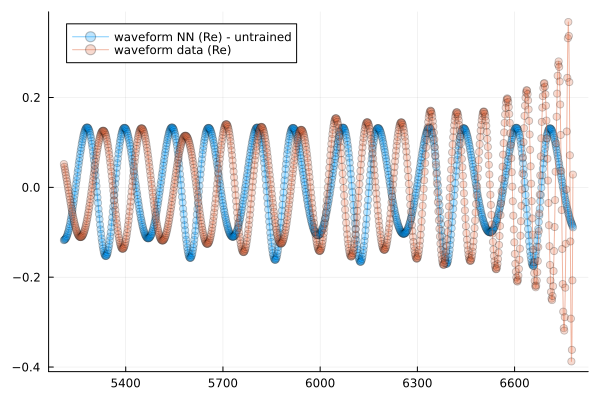

In [12]:
# Solving the edo without training
prob_nn = ODEProblem(ODE_model, u0, tspan, NN_params_final)
soln_nn = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params_final, saveat = tsteps, dt = dt, adaptive=false))
waveform_nn_real, waveform_nn_imag = compute_waveform(dt_data, soln_nn, mass_ratio)

# Plotting the solution without training
plot(tsteps, waveform_nn_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform NN (Re) - untrained")
Plots.plot!(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Re)")

In [13]:
## Define the loss function
function loss(NN_params_final; saveat=tsteps)
    tspan = (saveat[1],saveat[end])
    pred_soln = solve(remake(prob_nn, p = NN_params_final, tspan=tspan), RK4(),
                            saveat = saveat, dt = dt, adaptive=false, sensealg=BacksolveAdjoint(checkpointing=true))
    pred_waveform_real, pred_waveform_imag = compute_waveform(dt_data, pred_soln, mass_ratio)
    p = pred_soln[3,:]
    e = pred_soln[4,:]

    N = length(pred_waveform_real)
    loss = 1/N * (
            sum(abs2, waveform_real[1:N] .- pred_waveform_real)
        + 1.0f3*sum(abs2, max.(d_dt(p,dt_data),0.0))
        + 1.0f2*sum(abs2, max.(d2_dt2(p,dt_data),0.0))
        + 1.0f1*sum(abs2, max.(-e,0.0))
        + 1.0f0*sum(abs2, max.(e[p .>= 6 + 2*e[1]] .- e[1],0.0)))
        + 1.0f-1*sum(abs2, NN_params_final)

    return loss, pred_waveform_real, pred_waveform_imag, pred_soln
end

loss (generic function with 1 method)

In [14]:
# Test loss function
loss(NN_params_final)

const losses = []

callback(θ,l,pred_waveform_real, pred_waveform_imag, pred_soln; doplot = true) = begin
    push!(losses, l)
    display(l)
    #plt1 = plot(tsteps, waveform_real,markershape=:circle, markeralpha = 0.25,linewidth = 2, alpha = 0.5,label="wform data (Re)", legend=:topleft)
    #N = length(pred_waveform_real)
    #plot!(plt1, tsteps[1:N], pred_waveform_real,markershape=:circle, markeralpha = 0.25,linewidth = 2, alpha = 0.5,label="wform NN (Re)")

    #pred_orbit = soln2orbit(pred_soln)
    #orbit_nn1, orbit_nn2 = one2two(pred_orbit, mass1, mass2)
    #N = size(orbit_nn1,2)
    #plt2 = plot(x[1:N],y[1:N],linewidth = 2, alpha = 0.5,label="orbit data")
    #plot!(plt2, orbit_nn1[1,1:end], orbit_nn1[2,1:end],linewidth = 2, alpha = 0.5,label="orbit NN")
    #χ = pred_soln[1,:]
    #ϕ = pred_soln[2,:]
    #p = pred_soln[3,:]
    #e = pred_soln[4,:]
    #plt3 = plot(tsteps[1:N], p, linewidth = 2, alpha = 0.5, label="p", legend=:best)
    #plt4 = plot(tsteps[1:N], e, linewidth = 2, alpha = 0.5, label="e", legend=:topleft)
    #plt = plot(plt1, plt2, plt3, plt4, layout= @layout [a; [b{0.6w} [c;d]]])

    #if doplot
    #    display(plot(plt))
    #end
    # Tell sciml_train to not halt the optimization. If return true, then
    # optimization stops.
    return false
end

callback (generic function with 1 method)

In [15]:
optimization_increments = [collect(30:5:num_optimization_increments-5)..., num_optimization_increments-1, num_optimization_increments]

for i in optimization_increments
    println("optimization increment :: ", i, " of ", num_optimization_increments)
    tsteps_increment = tsteps[tsteps .<= tspan[1] + i*(tspan[2] - tspan[1])/num_optimization_increments]
    tmp_loss(p, _) = loss(p, saveat=tsteps_increment)

    NN_params_final = NN_params_final .+ Float64(1e-6) * randn(eltype(NN_params_final), size(NN_params_final))
    optf = Optimization.OptimizationFunction(tmp_loss, Optimization.AutoZygote())
    optprob = Optimization.OptimizationProblem(optf, NN_params_final, nothing)  # `nothing` as the dummy parameter
    
    if i < optimization_increments[end-1]
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=50)
    elseif i == optimization_increments[end-1]
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=100, allow_f_increases=true)
    else
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=250, allow_f_increases=true)
    end
    
    NN_params_final = res.minimizer
    #plt = plot(losses, yaxis=:log, linewidth=2, xlabel="Iteration", ylabel="Objective value", legend=false)
    #display(plt)
end

0.028703662328456867

0.02852874608488259

0.027436623788725335

0.025652261920774775

0.025434906173729604

0.025251096448120375

0.02524119900972458

0.025221158679788743

0.02517224360355062

0.02503978294580308

0.024709716230747705

0.02392643025503174

0.021879139657815953

0.02088699140263651

0.017900105115676187

0.015599768748909877

0.013635404038147246

0.0061339846008774245

0.005577092921468395

0.005272774994057964

0.004985733637289099

0.004067363345202634

0.0038185616426925553

0.0035174951590936318

0.003355018635141903

0.0033069314093773124

0.0033033632939709063

0.003300898823397527

0.0033001786113356648

0.0032999621068818324

0.0032998414793977545

0.0032994613274064184

0.0032985692252036603

0.003296440788581959

0.0032912618045523342

0.0032872951496886282

0.0032853469117377007

0.003284680249703688

0.003284483440429007

0.003284445959605714

0.0032843847953157005

0.0032843011254236436

0.0032839666302145634

0.003283077397915875

0.0032808982226286516

0.003276236525294526

0.0032696821413308094

0.0032522296458284343

0.003199229110527306

0.0031820568610580187

0.0031764316679098827

optimization increment :: 30 of 100
optimization increment :: 35 of 100
optimization increment :: 40 of 100
p = -90.87542300529762
p = -17.682972262673584
p = -235.02227783203125
p = -31.62027813072683
p = -76.64810241212706
p = -111.92928552627563
p = -48.13734070644678
p = -273.8519543678656
p = -100.4183133359565
p = -68.02279663085938
p = -199.02023835336638
p = -95.43343172471026
p = -130.71461725234985
p = -66.922672432521
p = -292.6372860939398
p = -119.20364506203072
p = -86.8081283569336
p = -261.0225486661566
p = -157.83088375269475
p = -125.43537139892578
p = -299.64979170814877
p = -196.45812679468693
p = -164.06261444091797
p = -239.86895164791235
p = -51.43810979364736
p = -238.7065994498293
p = -206.31108856201172
p = -210.1958429037124
p = -173.91557360190166
p = -218.93585883638164
p = -186.54033660888672
p = -262.3466738158811
p = -154.14482164877666
p = -248.3481933730856
p = -215.95267486572266
p = -236.70630087403674
p = -183.5571599056126
p = -239.8233595845015
p 

0.0030272667848866863

0.0030257901602449623

0.0029966050686359986

0.0029853221040928575

0.002984507504617344

0.0029834830607615294

0.0029819967874493507

0.0029802330990050634

0.002978469935921062

0.002977926303135798

0.0029769425847173256

0.0029761212552417995

0.0029693166504177176

0.0029646459417307495

0.002961451182101264

0.002958593596303226

0.002958460245645092

0.002958146288454843

0.002958050347829573

0.0029580168310672328

0.002957470690252752

0.002956562445365323

0.002954034755407298

0.002949407285234283

0.002940628185445322

0.002932217487619721

0.0029159536637020926

0.0029105070398662385

0.0029028767881881593

0.0028840562919892954

0.0028682649198486384

0.0028608275456004748

0.002854326525090357

0.0028397641680090444

0.002839148462200089

0.002834736774758877

0.0028326749789869795

0.0028283979925242033

0.0028261871293724615

0.0028238947784059824

0.0028221709257785334

0.002821307692549816

0.002820562859774116

0.002820405122621816

0.002820100720678013

0.002819418132981506

0.002817639992847513

0.0028130882552925085

0.00280090204525159

0.0027774748872385732

0.002767318780394794

0.002680106154839739

0.0026764562844056017

0.0026758945647447985

0.002671051744038635

0.0026586544711987483

0.0026574169314591985

0.0026556564281811175

0.002653470942539192

0.0026504567338598213

0.002640113285038512

0.002631768361805861

0.0026274192415163813

0.0026133502967661936

0.00260995264828481

0.0026066105175817536

0.0026005062911512674

0.0026002378893689388

0.0025966470442933998

0.0025919150675084053

0.002584221676005071

0.002576819752676869

0.0025478848860353105

0.0025390104867349878

0.0025233051968208287

0.002515538793240967

0.0025021224134905156

0.002486883575666939

0.0024726128597862287

0.00246342350689281

0.002461524213061313

0.0024590122367175926

0.0024568058773886334

0.0024545953111403448

0.0024535822944897413

0.0024530095481781517

0.0024516044859134124

0.0024485863185378614

0.0024419124202194847

0.002439802063947911

0.0024268917934359142

0.0024194584555702766

0.0024112599589413484

0.002406882657648581

0.0024060463257776347

0.002400407617569333

0.0023940670364516843

0.002377994769724735

0.002370821276927283

0.0023554770294593806

0.0023464429457262363

0.00232947530908287

0.0022066261339189416

0.0022025514579924557

0.002178502913326528

0.0021755836610992856

0.0021744121340036204

0.00217082977245785

0.0021673197415846813

0.0021654675344328495

0.0021641538638127503

0.002162666414980922

0.0021609697185275933

0.002159954442167964

0.0021595183977591945

0.002159039511445901

0.002157285653516508

0.0021520977435957513

0.002135730133684945

0.002134776938877065

0.0021211488746635376

0.00211192738793287

0.002111317218953818

0.00210932360696365

0.002108535384826986

0.0021083229834385447

0.00210790784610072

0.002107092530476528

0.0021059775591269754

0.0021048648563178384

0.0021039689558364164

0.002103193523512955

0.002101120664090408

0.0020958541149411554

0.0020906347658170748

0.002087332547280684

0.00208209369537998

0.0020654392435461616

0.002053829437575316

0.0020325824418811916

0.0020308805565022285

0.0020231142410770315

0.002012460525320939

0.001996112615951613

0.001989806150576215

0.0019753100532071553

0.0019645735656667346

0.0019597961674346232

0.00194973526627176

0.0019397177562293104

0.0019292010722267857

0.001901866462354568

0.0018925708169674922

0.002085757354722247

0.002073845805221311

0.0020450236308406228

0.0018842915916053129

0.0018728237012374436

0.001871803814675491

0.0018695561804057946

0.0018644973528491545

0.0018539023953896626

0.001840910347652614

0.001830327230903206

0.0018212782007021966

0.001819355348746521

0.001817567726429726

0.0018125058212698773

0.0018012544660025416

0.001770194903033737

0.001732358353525168

0.001713994485242007

0.0016979204787867623

0.0016901279249751343

0.0016828178521482262

0.0016778352271731257

0.0016748799815779587

0.0016691011872627408

0.001664039284813144

0.0016597530698599795

0.0016580318982883009

0.0016579967448772073

0.001657674184935735

0.0016576069689327778

0.0016574181363606805

0.0016518472365962974

0.001644136009263569

0.0016239087105160632

0.0016104810332406624

0.0016049744371888172

0.001600426881057258

0.0015966184717367562

0.0015946871617514686

0.0015931653728079235

0.0015924428286928137

0.0015918705195442776

0.001591718650910164

0.0015916294766691358

0.0015915868349671825

0.0015915369799265027

0.0015914121119166911

0.0015911452145512077

0.001590415628348718

0.0015889196583710598

0.0017025920948824647

0.0016422706327668315

0.001596017922766356

0.0015917326110724565

0.0015889919574981917

0.0015744090980441148

0.0015604445727302532

0.0015482634382067604

0.0015426287310893916

0.0015409875183531184

0.001539662604950325

0.0015382303886246167

0.0015375524914454971

0.0015372893682377954

0.001537004384835781

0.0015362100509328498

0.0015342876551664398

0.0015296587911788962

0.0015211825183611312

0.0015164473987091356

0.00151482476079095

0.0015140684910591705

0.0015137785107029293

0.0015137524170154635

0.0015137190224353094

0.0015136220245621627

0.0015133774431132486

0.001512713993811971

0.0015111612600485192

0.001508370793629484

0.0015042542799173094

0.001498572904101599

0.0014945043056684133

0.0014933804035853998

0.0014909355894977127

0.0014894885237566274

0.0014870070067814199

0.0014865581740419011

0.001486160997914575

0.001486039672382945

0.001485980870738815

0.001485954482192011

0.0014859018180461265

0.001485738123403576

0.001485344135333822

0.0014842736800996924

0.0014818675758310079

0.0014772432659097053

0.001476368040233208

0.00147453610798741

0.0014734216638703425

0.0015015683857623604

0.0014974950363866705

0.0014957411005679293

0.0014647055022401893

0.0014632590166005614

0.001462832968366022

0.0014623662772388262

0.0014618994832253397

0.0014602353463239294

0.001457221475792429

0.0014522200923706365

0.0014480882116693426

0.0014465995253749417

0.001445754996417181

0.001444741511412001

0.0014430780295778128

0.0014399384500699442

0.001436724874114415

0.00143500000926572

0.0014344231284516894

0.0014343475688070426

0.001434282431532062

0.0014341265824617817

0.0014337298456830383

0.001432733167551175

0.0014307008547944733

0.0014281002751629535

0.0014268003877958182

0.0014263380462035315

0.0014261931120876244

0.0014261009337982753

0.0014260554759879882

0.0014260324676934847

0.001425856560334784

0.0014254661357384459

0.0014244542137969484

0.0014220841723208122

0.001418137818164638

0.0014132547932943437

0.001411702992039133

0.0014092351000718666

0.0014087419950072017

0.0014085045631132688

0.001408153764226032

0.0014080088406700905

0.0014078317629937277

0.0014077806222714982

0.0014077537879377796

0.00140772965772054

0.001407663618900976

0.0014074955510721015

0.0015422079233483603

0.0015304837726500512

0.0015298913653254826

0.0014999131390983022

0.0014980709856043035

0.0014892261872416542

0.0014796750874354547

0.001475082076278644

0.0014692832798975308

0.0014636855037098234

0.0014624894590124977

0.001460715178675047

0.0014564151416272065

0.0014478338043067808

0.0014341873865431967

0.0014211505807111555

0.0014147286087182083

0.0014138488126987148

0.0014136902197056844

0.0014136375927092503

0.001413556037027127

0.0014129870849649145

0.001411898460667679

0.001409449807582497

0.001407339803991364

0.0014060348371238468

0.0014056507454708743

0.0014055545264047523

0.0014054889750298714

0.001405382356522876

0.0014052228641851865

0.0014046264990450568

0.0014033015813977217

0.0013999439680538381

0.0013956938951997847

0.0013939455921287928

0.0013917722479175523

0.0013905197016401698

0.0013899136547357537

0.0013892774498212345

0.0013881649671994784

0.0013879399045368566

0.0013878018371410341

0.001387704805464311

0.0013876270725645345

0.0013876057823184913

0.001387536461810729

0.001387507125482094

0.0013874860851802893

0.00138737232957256

0.0013870444331334337

0.0018384968561981946

0.0016886392698520474

0.0016842763911751825

0.001645003561420657

0.0016020878481752192

0.0015845775919148888

0.001583004235961965

0.0015807557475942455

0.0015707938660533304

0.001559564853593568

0.001545090084580444

0.0015425639253088686

0.001541806630219262

0.0015411620608352654

0.001538229401377754

0.0015320641918187114

0.0015168104423057955

0.0014933854431405165

0.0014794018717889114

0.001477254293931399

0.0014756155608591454

0.0014752713715069227

0.001475106997973251

0.001475030340745982

0.0014749356070863301

0.0014748476716155336

0.0014746961960938412

0.0014743311315681428

0.0014732982512422937

0.0014699462510866363

0.0014674672136503883

0.0014635569278550898

0.0014598882677166161

0.0014578673659395465

0.0014563930721841285

0.001455396987703549

0.0014547081748671241

0.0014544201490178806

0.001454034885007981

0.001453562233694091

0.0014532169100219259

0.0014531484275216707

0.0014531318621339106

0.0014531059582483105

0.0014530864297715013

0.001453030383047543

0.0014529051392282624

0.0014525671870984018

0.0014516467429722413

0.0014483361377609111

0.0014364019354863558

0.001568040562922771

0.0015261291127341007

0.0014966151394065084

0.0014827577034390996

0.0014589890849151614

0.0014480822269195084

0.0014365031781323134

0.0014348248572728269

0.0014336360223215243

0.0014335053794946675

0.0014332810022693787

0.001432742087511919

0.0014314143204966433

0.0014283669268988703

0.0014268885410892694

0.001424895966745103

0.0014239188190098048

0.0014236909243561312

0.0014236349879175635

0.0014231636655053894

0.001422456442300427

0.0014213656582155979

0.0014196768330368636

0.0014174450054074985

0.001415445175345931

0.0014137296690256696

0.0014131194441874184

0.0014130017611641125

0.0014128278562614953

0.0014127726439268245

0.00141189172205954

0.001411046836810354

0.0014074498554663421

0.001401730429777696

0.0013948735309144678

0.0013921536810041644

0.0013878030946669361

0.001384804736478273

0.0013844341246006305

0.0013834252434569046

0.0013824600640907582

0.0013813631584075167

0.0013806345474993266

0.0013796729414273336

0.0013766767418317422

0.0013732010517793374

0.001370784295155407

0.001369398690417051

0.001366371076053726

0.001362997360909613

0.0013593555963668672

0.002012123683287243

0.001958853043807672

0.001942680054471814

0.0019142693851865158

0.0018921774517993398

0.0018595833014469225

0.001847627981870403

0.0018169091422773442

0.001808451050676515

0.0017956611331317195

0.0017685966110367365

0.001706488508743433

0.0016182406826799017

0.0015400410897647597

0.0015124402138882273

0.0014962909349146441

0.0014872119705538831

0.0014861039526825079

0.0014857499627816586

0.001484744977315785

0.00148448657173618

0.0014831062036574445

0.0014816858271407172

0.0014782230939806723

0.001475129150670082

0.0014731009029644276

0.0014729000103475384

0.0014728369890656757

0.0014728071266519789

0.0014727268175546305

0.0014724983460526174

0.0014718054132266578

0.001469632597343346

0.001468497279279103

0.001465991518112544

0.0014645808499577767

0.0014605891791058334

0.0014544722440965054

0.001454026118539598

0.0014526044926931182

0.001451842884480479

0.0014505587872493978

0.0014502215699683885

0.0014461476451169764

0.0014441010004085653

0.0014418913684633905

0.0014413511397994429

0.001436677007201087

0.0014335800819419242

0.001430138991703144

0.0014278148780899507

0.0024564030408587663

0.002409017251027585

0.0024080804439041556

0.0023331257672779713

0.0022442711035612862

0.002221449097279451

0.002194994014653161

0.0021697985315945988

0.002155269229500667

0.002143142399293377

0.0021061840205356813

0.0020370143951854284

0.0019372167633708616

0.0018234750299339435

0.0017949440155159114

0.0017005956105845383

0.0016714258098569758

0.0016671738862175532

0.0016628004435794816

0.0016532761658201885

0.0016409623090964621

0.0016390388155686213

0.0016378591494738467

0.001636761505436634

0.0016365761115536884

0.001636156932901343

0.0016357171434475204

0.0016344260735619528

0.0016317309483646482

0.0016259626263285232

0.001616627443836267

0.0016081386488605086

0.0016038303126846957

0.0016028153778726065

0.0016022806973980026

0.0016019898481506977

0.001601812321019611

0.0016015178382163746

0.0016008608237486587

0.0015995109105264925

0.0015971568205083526

0.0015941647025328781

0.0015905483431518821

0.0015886445772195332

0.0015885058189473846

0.0015883988050709324

0.001588249086797181

0.0015879727650048789

0.0015870221433741001

0.0015841193557356776

0.0015798919182260646

0.0028464329932105137

0.002728037118350101

0.0027236608347309594

0.0026800747933334802

0.002494714111015785

0.002480436610961857

0.0024781792642794937

0.002454315743163183

0.00242522794489623

0.0023751537089988133

0.002339989748157909

0.002301424177447272

0.0022617916047930607

0.0021835869640223354

0.0021399902745099435

0.0021183722272380494

0.0021112884159125668

0.0021066684718768955

0.002104805390858567

0.0021041827684826963

0.002102543107394597

0.0021004387085494123

0.0020950672584390787

0.002081984967171343

0.0020627482946065094

0.002055481678551415

0.0020386894908076777

0.0020260765622599794

0.002006743943947573

0.0019946770039614074

0.0019868230963856013

0.001980596231718478

0.0019788168577183607

0.001978152287883637

0.001977400854620759

0.001976732499729999

0.0019760495415434417

0.0019743250712150624

0.0019703675598371187

0.001959819535856454

0.0019244764707756546

0.0018843153738791907

0.0018478318604444007

0.0018171281537921829

0.0017636848445253712

0.001696287512262256

0.001637656479945403

0.0016078290689011021

0.0015776987572972217

0.0015743705202984017

0.0015723809643732186

0.004488275307188722

0.004473522074930917

0.0044725769488378865

0.004428416097878754

0.004252500833388676

0.004202263916151182

0.0041387337333352835

0.0040809264735533575

0.004018173429028424

0.003706639856926419

0.003330080402443878

0.0031238483980963925

0.0029294236648474184

0.0026548856464136466

0.0025970457018292766

0.002528298995459136

0.002457043700292354

0.002370169121004926

0.0023613809072552654

0.0023521951160770244

0.0023237375297866444

0.0023155526741938355

0.0023010602407360537

0.002294770802461894

0.002276682321732885

0.002262570853101204

0.002238188957147799

0.002211468884238903

0.0021881958985790653

0.002175310287985369

0.0021582825147411005

0.002140924676384729

0.0021372294479842864

0.0021317960999114468

0.002122433049848035

0.002096585127484256

0.0020658394659650446

0.002054601871490465

0.0020459307915844317

0.00200068306811687

0.00199692644256262

0.0019925017115846773

0.00199167175331125

0.0019893079867666814

0.0019855507148910222

0.0019742918974930196

0.001943956175449171

0.0019314443600190333

0.001890715706216719

0.0018576418204799502

0.001815636559011338

0.004893744053391652

0.00488111282549642

0.004880572323663827

0.0048796023155068275

0.004879525321094381

0.00487942643010286

0.004877083310903019

0.00487096066726096

0.004870775794963152

0.0048704700075708944

0.004870401231451164

0.0048703336651828655

0.004869291585251814

0.004862184228485528

0.00485836841938153

0.004811794687238191

0.0047737431441316714

0.0047324698010641035

0.004707320611145541

0.004703379874833261

0.004697090204263491

0.004693522392548295

0.004690197701387598

0.00468933024443255

0.004688230671792167

0.004685130358596985

0.004676039816647912

0.004630319714779432

0.0046076095659875575

0.0045555456891998615

0.004500917814423843

0.004397437676307745

0.004298309872137155

0.0041976523119062305

0.004059082112692076

0.003746747830160093

0.003609287733311194

0.003545158282609113

0.0034485134967339893

0.0033959174431133833

0.0033744536633136544

0.0033349700489091185

0.0033222947344462655

0.003318816231342527

0.0033128837932506717

0.0032874855809980844

0.003258435829699099

0.0032152922384931955

0.0031718714412198876

0.0030988378730988798

0.0030163593572476734

0.00290529180401625

0.0027853164700875257

0.0026422348085076933

0.0026145400488783

0.002559980340112132

0.002544223520995135

0.002518646416009998

0.0023735333046226268

0.0022972605288032123

0.002232783032517543

0.002193074565511342

0.0021867218385657875

0.0021836392036751785

0.002176189455376363

0.002173749951050828

0.0021652514045891746

0.002151381235910953

0.0021279329479402536

0.0020808729227973772

0.0020582556996304553

0.0020116812380630788

0.0018840294504508116

0.0016761393551084018

0.0015207120196437272

0.0013819418490106717

0.0012779583523353495

0.0012398135242424788

0.0012159353447183812

0.0012046059084326178

0.0012014213654961536

0.0011976501796979433

0.0011965393033147717

0.0011954308820898002

0.0011945821532318467

0.0011939801641473059

0.001193836975788828

0.0011937756050417205

0.0011936170198074123

0.0011934433324387191

0.0011932657343816143

0.0011931582120696758

0.001193111313207715

0.0011930418429874383

0.0011929135333402364

0.001192752366794272

0.0011924048136802419

0.0011918154804769767

0.0011907610215487975

0.0011901355975527093

0.0011885045396452215

0.0016118392651241825

0.0016093134095784716

0.0015986426189227544

0.0015949786341375683

0.0015917780271188877

0.001588478251139911

0.0015784602151082698

0.0015700709164294107

0.0015627049146773532

0.0015596665162385785

0.001555822810569611

0.0015465084719758608

0.001529094062897648

0.0015032631691398294

0.001480709867606722

0.0014646679817992443

0.0014582843463590413

0.0014557547700934203

0.00145515750103533

0.001455067455092465

0.001454898748140697

0.001454592818539368

0.0014537747216389295

0.0014523891456452518

0.0014506095055591113

0.001450329124763893

0.001450115968610957

0.0014500944887270509

0.0014500692508420383

0.0014500255159091893

0.001449733813591531

0.0014491764706947104

0.0014480503925401202

0.0014473473831833512

0.0014466143962475547

0.001445890460896607

0.0014457271508532142

0.00144559411118417

0.001445400852627714

0.0014448752778073752

0.0014435548473629893

0.0014399391780105285

0.0014378968901290633

0.0014272124554998667

0.0014243727593613795

0.0014126502759836566

0.0013935567333864007

0.0013872304512838425

0.0013853518581798854

0.00137943304008736

0.0013772853659321032

0.0013750266629211755

0.0013706057008628944

0.0013686041669570082

0.0013657978037912824

0.0013600629937933913

0.0013587321861111901

0.0013567365926487615

0.0013543084439852306

0.001351125129699876

0.001349438602208916

0.0013446424399518072

0.0013433134067446207

0.0013423799633259404

0.001339438836045672

0.0013386844197691723

0.001334991093031207

0.0013345746741290423

0.0013300768639438621

0.001327589585482852

0.001325900294945361

0.0013239327693465187

0.0013217630843954482

0.0013193063491762083

0.001317748129624587

0.001316763728337507

0.001314713649017442

0.0013125071981031345

0.0013113343716965866

0.0013106593690243589

0.0013100908724093345

0.0013098954919559002

0.0013093014316659752

0.0013089279099546783

0.0013088576324806463

0.0013087639367644012

0.0013087031488294416

0.0013086084100359231

0.0013085569567801874

0.0013085359923210626

0.0013084017899913762

0.0013081121241484102

0.0013072166004817246

0.0013069329530913478

0.0013066990908185514

0.001306138233336121

0.0013050772077641195

0.0013035969642260809

0.0013025622566542534

0.0012996797403834204

0.0012990542101139822

0.0012974214754646895

0.0012960172125262514

0.0012927837983398851

0.001292350822660958

0.0012899552305125363

0.0012886477308228588

0.0012880309521113283

0.0012878406301716377

0.00128777281899067

0.0012877454359586785

0.0012877266374558124

0.001287725797234423

0.001287693404406769

0.0012876039068439513

0.00128758103679917

0.0012875320949782098

0.0012875166803581854

0.001287472458128504

0.0012873714679198236

0.0012872297703334467

0.0012870236792504408

0.001286845353294496

0.001286517276696837

0.0012860140630638855

0.0012857856164432003

0.0012856265100517842

0.0012853864605016634

0.001285302484731293

0.001285268734481477

0.0012852635360418552

0.0012852614587666564

0.001285261342313139

0.0012852612869433111

0.0012852595564572433

0.0012852590805418822

0.0012852590805418822

0.0012852506023449943

0.0012852477928924691

0.0012852427512972282

0.0012852418495252484

0.0012852400986523116

0.0012852270930504386

0.001285218838519787

0.0012851641905970146

0.0012849798972495727

0.0012848837672490973

0.001284764969111787

0.0012847294335620308

0.0012846919770900266

0.0012846432691916957

0.0012846155258592381

0.0012845476813973498

0.001284538718985925

0.0012844668939666285

0.001284466731542946

0.0012844667279669477

0.0012844667212316486

0.0012844667212316486

0.0012844667212316486

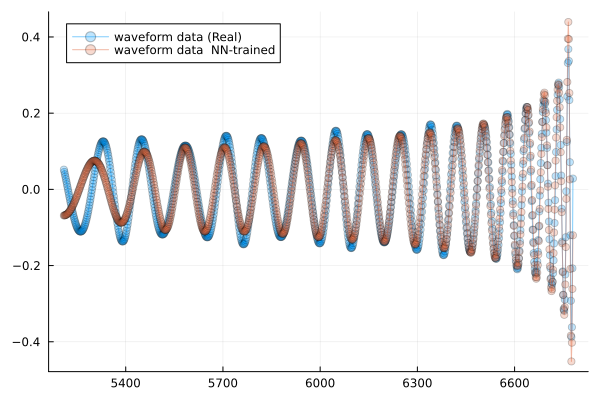

In [16]:
# Optimizez solution and getting the waveform
optimized_solution = solve(remake(prob_nn, p = NN_params_final, tspan=tspan), RK4(), saveat = tsteps, dt = dt, adaptive=false)
pred_waveform_real, pred_waveform_imag = compute_waveform(dt_data, optimized_solution, mass_ratio)

# Plotting the NN and real waveform
plot(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Real)")
Plots.plot!(tsteps, pred_waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data  NN-trained")

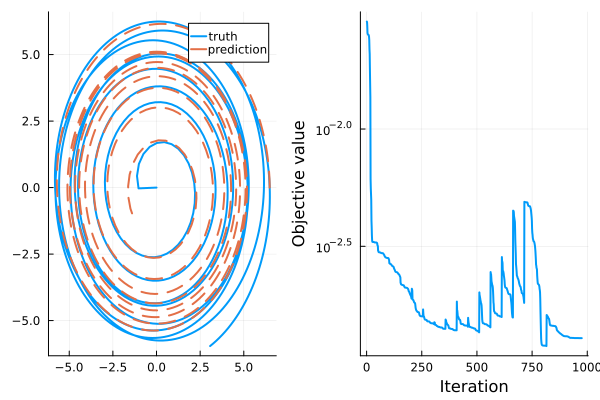

In [17]:
# Plotting the shape of the orbit and the loss function
pred_orbit = soln2orbit(optimized_solution)
orbit_nn1, orbit_nn2 = one2two(pred_orbit, mass1, mass2)
plt1 = plot(x, y, linewidth = 2, label = "truth")
plot!(plt1, orbit_nn1[1,:], orbit_nn1[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plt2 = plot(losses, yaxis=:log, linewidth = 2, xlabel = "Iteration", ylabel = "Objective value", legend = false)
plt = plot(plt1, plt2, layout = (1,2))
display(plot(plt))

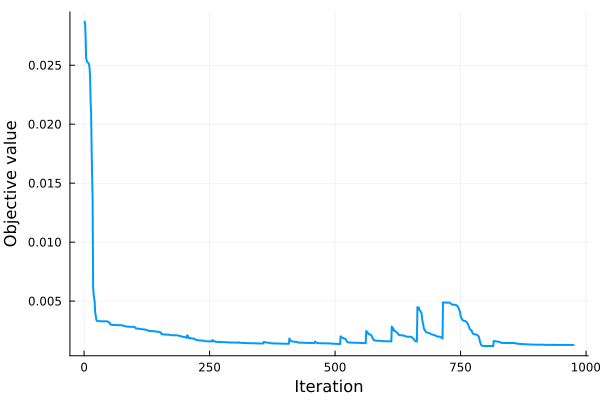

In [18]:
plot(losses, linewidth=2, xlabel="Iteration", ylabel="Objective value", legend=false)

In [19]:
df_solution = DataFrame(time = tsteps[1:length(optimized_solution)],
                        χ = optimized_solution[1,:],
                        ϕ = optimized_solution[2,:],
                        p = optimized_solution[3,:],
                        e = optimized_solution[4,:])

Row,time,χ,ϕ,p,e
,Float32,Float32,Float32,Float32,Float32
1,5209.13,3.14159,0.0,11.8667,0.085
2,5210.7,3.15085,0.024967,11.8595,0.0852323
3,5212.27,3.16012,0.0499613,11.8524,0.0854513
4,5213.85,3.16941,0.0749687,11.8453,0.0856571
5,5215.42,3.17871,0.0999978,11.8382,0.08585
6,5216.99,3.18804,0.125058,11.8311,0.0860304
7,5218.56,3.19738,0.150134,11.824,0.0861983
8,5220.14,3.20674,0.175243,11.8169,0.086354
9,5221.71,3.21611,0.20037,11.8099,0.0864978


In [20]:
df_trajectories = DataFrame(time = tsteps,
                         true_orbit_x1 = x,
                         true_orbit_y1 = y,
                         true_orbit_x2 = x2,
                         true_orbit_y2 = y2,
                         pred_orbit_x1 = orbit_nn1[1,:],
                         pred_orbit_y1 = orbit_nn1[2,:],
                         pred_orbit_x2 = orbit_nn2[1,:],
                         pred_orbit_y2 = orbit_nn2[2,:])

Row,time,true_orbit_x1,true_orbit_y1,true_orbit_x2,true_orbit_y2,pred_orbit_x1,pred_orbit_y1,pred_orbit_x2,pred_orbit_y2
,Float32,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5209.13,3.07049,-5.95716,-3.07049,5.95716,6.48453,0.0,-6.48453,-0.0
2,5210.7,3.25188,-5.85863,-3.25188,5.85863,6.48022,0.161825,-6.48022,-0.161825
3,5212.27,3.43008,-5.75426,-3.43008,5.75426,6.47173,0.323606,-6.47173,-0.323606
4,5213.85,3.60481,-5.64421,-3.60481,5.64421,6.45906,0.485136,-6.45906,-0.485136
5,5215.42,3.77595,-5.52854,-3.77595,5.52854,6.4422,0.646362,-6.4422,-0.646362
6,5216.99,3.94336,-5.40734,-3.94336,5.40734,6.42116,0.807228,-6.42116,-0.807228
7,5218.56,4.10673,-5.28071,-4.10673,5.28071,6.39596,0.967529,-6.39596,-0.967529
8,5220.14,4.26603,-5.14877,-4.26603,5.14877,6.36659,1.12726,-6.36659,-1.12726
9,5221.71,4.421,-5.01173,-4.421,5.01173,6.33307,1.28622,-6.33307,-1.28622


In [21]:
df_waveforms = DataFrame(time = tsteps,
                        true_waveform_real = waveform_real,
                        true_waveform_imag = 0*waveform_real, # not recorded
                        pred_waveform_real = pred_waveform_real,
                        pred_waveform_imag = pred_waveform_imag,
                        error_real = waveform_real .- pred_waveform_real,
                        error_imag = 0*waveform_real) # not recorded

Row,time,true_waveform_real,true_waveform_imag,pred_waveform_real,pred_waveform_imag,error_real,error_imag
,Float32,Float64,Float64,Float64,Float64,Float64,Float64
1,5209.13,0.0518528,0.0,-0.0686218,-0.000407007,0.120475,0.0
2,5210.7,0.045844,0.0,-0.0683017,0.00389632,0.114146,0.0
3,5212.27,0.0396489,0.0,-0.0679817,0.00819966,0.107631,0.0
4,5213.85,0.0332933,0.0,-0.067577,0.0112377,0.10087,0.0
5,5215.42,0.0267974,0.0,-0.0670715,0.0142684,0.0938688,0.0
6,5216.99,0.0201854,0.0,-0.0660876,0.0184839,0.086273,0.0
7,5218.56,0.0134858,0.0,-0.0653895,0.0210554,0.0788753,0.0
8,5220.14,0.00671926,0.0,-0.0639753,0.0251593,0.0706946,0.0
9,5221.71,-8.51954e-5,-0.0,-0.0628149,0.0280283,0.0627297,-0.0


In [22]:
df_losses = DataFrame(losses = losses)

Row,losses
,Any
1,0.0287037
2,0.0285287
3,0.0274366
4,0.0256523
5,0.0254349
6,0.0252511
7,0.0252412
8,0.0252212
9,0.0251722


In [23]:
df_parameters = DataFrame(parameters = NN_params)

Row,parameters
,Float64
1,0.23588
2,-0.207245
3,-0.375848
4,0.161626
5,0.0227079
6,-0.245345
7,0.144859
8,0.254054
9,-0.378633


In [24]:
CSV.write("./output/SXS1356_solution.csv", df_solution)
CSV.write("./output/SXS1356_trajectories.csv", df_trajectories)
CSV.write("./output/SXS1356_waveforms.csv", df_waveforms)
CSV.write("./output/SXS1356_losses.csv", df_losses)
CSV.write("./output/SXS1356_parameters.csv", df_parameters)

"./output/SXS0217_parameters.csv"